# Does principle component variance of activation follow power law?



Inspired from https://www.youtube.com/watch?v=kw35hsXE3jk and Anthony Chen's ideas. Additional thanks to Blake, Shahab and Arna. 

Paper link: https://www.nature.com/articles/s41586-019-1346-5

Code chunk used from: https://github.com/AvivSham/Pytorch-MNIST-colab/blob/master/Pytorch_MNIST.ipynb


### Results 

It kinda does. t depends a lot on where we cut the tail though. If I cut it at 1000 components, slope = -0.582157. If I cut it at 2000 components, slope=-0.74169948. If I cut it at 2000 components, slope=-0.96241085. 

So the activations in CNNs are not too crazy far from brain, atleast according to this measure.

*   Blake: "you measure the slope in the straight part. If it's close to 1, that is what they found in cortex, if I recall correctly. Less than 1 indicates lower dimensionality. Greater than 1 indicates fractal structure. I think he told me that convnets have greater than 1?"

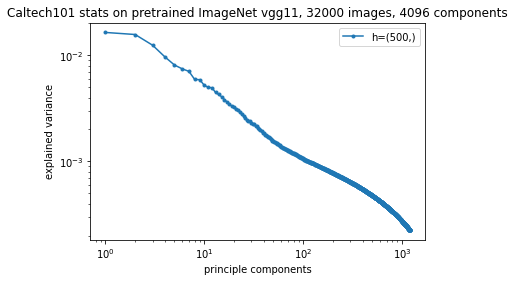

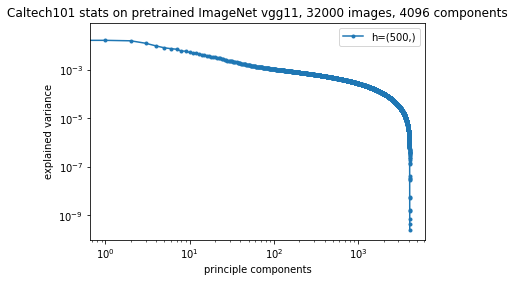

### Setting things up

In [0]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt

### Code to train MNIST

In [0]:
input_size = 784 # img_size = (28,28) ---> 28*28=784 in total
hidden_size = 500 # number of nodes at hidden layer
num_classes = 10 # number of output classes discrete range [0,9]
num_epochs = 2 # number of times which the entire dataset is passed throughout the model
batch_size = 64  # the size of input data took for one iteration
lr = 1e-3 # size of step

In [0]:
train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = dsets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

In [0]:
train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size, 
                                      shuffle = False)

In [0]:
class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)
  
  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

In [0]:
net = Net(input_size, hidden_size, num_classes)
if torch.cuda.is_available():
  net.cuda()

In [0]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( net.parameters(), lr=lr)

In [0]:
for epoch in range(num_epochs):
  for i ,(images,labels) in enumerate(train_gen):
    images = Variable(images.view(-1,28*28))
    labels = Variable(labels)
    
    optimizer.zero_grad()
    outputs = net(images)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()
    
    if (i+1) % 100 == 0:
      print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item()))

Epoch [1/2], Step [100/937], Loss: 0.5340
Epoch [1/2], Step [200/937], Loss: 0.3508
Epoch [1/2], Step [300/937], Loss: 0.2908
Epoch [1/2], Step [400/937], Loss: 0.2307
Epoch [1/2], Step [500/937], Loss: 0.2937
Epoch [1/2], Step [600/937], Loss: 0.1494
Epoch [1/2], Step [700/937], Loss: 0.1782
Epoch [1/2], Step [800/937], Loss: 0.0888
Epoch [1/2], Step [900/937], Loss: 0.2453
Epoch [2/2], Step [100/937], Loss: 0.0849
Epoch [2/2], Step [200/937], Loss: 0.1098
Epoch [2/2], Step [300/937], Loss: 0.1149
Epoch [2/2], Step [400/937], Loss: 0.0895
Epoch [2/2], Step [500/937], Loss: 0.0532
Epoch [2/2], Step [600/937], Loss: 0.1375
Epoch [2/2], Step [700/937], Loss: 0.0590
Epoch [2/2], Step [800/937], Loss: 0.0902
Epoch [2/2], Step [900/937], Loss: 0.0498


In [0]:
correct = 0
total = 0

for images,labels in train_gen:
  images = images.view(-1,28*28)
  labels = labels
  
  output = net(images)
  _, predicted = torch.max(output,1)
  correct += (predicted == labels).sum()
  total += labels.size(0)
train_acc = (100*correct.numpy())/(total+1)
print('Train accuracy of the model: %.3f %%' %(train_acc))
print(correct, total)

correct = 0
total = 0
for images,labels in test_gen:
  images = images.view(-1,28*28)
  labels = labels
  
  output = net(images)
  _, predicted = torch.max(output,1)
  correct += (predicted == labels).sum()
  total += labels.size(0)
test_acc = (100*correct.numpy())/(total+1)
print('Test accuracy of the model: %.3f %%' %(test_acc))
print(correct, total)


Train accuracy of the model: 98.020 %
tensor(58813) 60000
Test accuracy of the model: 97.310 %
tensor(9732) 10000


### Generate the activites in hidden layer activities for images

In [0]:
activities = []
def hook_fn(m, i, o):
  activities.append(i[0].numpy())

handle = net.fc2.register_forward_hook(hook_fn)

# Running through all training images
for images,labels in train_gen:
  images = images.view(-1,28*28)
  with torch.no_grad():
    out = net(images)

handle.remove()
print(len(activities), activities[0].shape)

938 (64, 500)


In [0]:
# Converting the activities to numpy
act_np = activities[0]
for c, act in enumerate(activities):
  if(c==0):
    continue
  act_np = np.vstack((act_np, act))

### Plots for explained variance on MNIST in hidden layers

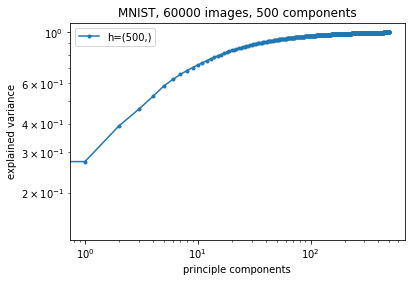

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components=500)
pca.fit(act_np)
plt.loglog(np.arange(500), np.cumsum(pca.explained_variance_ratio_), '.-',label='h=(500,)')
# ax.set_xscale("log", nonposx='clip')
plt.xlabel('principle components'), plt.ylabel('explained variance')
plt.title('MNIST, 60000 images, 500 components'), plt.legend()
plt.show()

### Testing the same ideas on ImageNet


In [0]:
import torchvision.models as models
from tqdm.notebook import tqdm
vgg16 = models.vgg11(pretrained=True).cuda()

In [0]:
from torchvision import transforms as T
transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.Grayscale(num_output_channels=3), T.ToTensor()])
train_data = dsets.Caltech101(root = './data', 
                        transform = transform, download = True)
print(train_data)

batches = 20
train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = 64,
                                             shuffle = True)

for k in train_gen:
  break

Files already downloaded and verified
Dataset Caltech101
    Number of datapoints: 8677
    Root location: ./data/caltech101
    Target type: ['category']
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               Grayscale(num_output_channels=3)
               ToTensor()
           )


In [0]:
BATCHES = 500

activities = []
def hook_fn(m, i, o):
  activities.append(i[0].cpu().numpy())

for name, m in vgg16.named_modules():
  if(name=='classifier.3'):
    print(name, m)
    handle = m.register_forward_hook(hook_fn)
    

# Running through all training images
for i, (images,labels) in tqdm(enumerate(train_gen)):
  if(i>=BATCHES):
    break
  with torch.no_grad():
    out = vgg16(images.cuda())

handle.remove()
print(len(activities), activities[0].shape)

classifier.3 Linear(in_features=4096, out_features=4096, bias=True)



136 (64, 4096)


In [0]:
# Converting the activities to numpy
act_np = activities[0]
for c, act in enumerate(activities):
  if(c==0):
    continue
  act_np = np.vstack((act_np, act))

In [0]:
from sklearn.decomposition import PCA
nc = 4096
pca = PCA(n_components=nc)
pca.fit(act_np)


PCA(copy=True, iterated_power='auto', n_components=4096, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

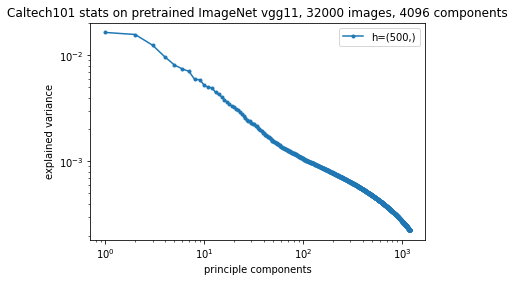

In [0]:
plt.loglog(np.arange(1,2000), pca.explained_variance_ratio_[1:2000], '.-',label='h=(500,)')
# ax.set_xscale("log", nonposx='clip')
plt.xlabel('principle components'), plt.ylabel('explained variance')
plt.title('Caltech101 stats on pretrained ImageNet vgg11, '+str(BATCHES*64)+' images, '+str(nc)+' components'), plt.legend()
plt.show()

In [0]:
# Slope estimates depend on variance
x = np.log(np.arange(10,3000)).reshape(-1,1)
y = np.log(pca.explained_variance_ratio_[10:3000]).reshape(-1,1)
print(x.shape, y.shape)
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x, y)
reg.coef_

(2990, 1) (2990, 1)


array([[-0.96241085]])